# Battery Pack Thermal Simulation - Realistic Scaling
This notebook is a cell-by-cell translation of the updated `trying.py` script, with all new scaling, pack architecture, and summary logic.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import butter, filtfilt
import os
from datetime import datetime

## Configuration and Paths

In [2]:
DRIVE_CYCLE_FOLDER = "/home/keshav/Documents"
CORE_CSV_PATH = "/home/keshav/Documents/reserch_code/core.csv"
OUTPUT_PATH = "/home/keshav/Documents/reserch_code/simulated_battery_cooling.csv"

os.makedirs("data", exist_ok=True)
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

FORCE_REBUILD_CORE = True
ADIABATIC_MODE = False  # Set True to disable cooling

## Realistic Battery Pack Configuration

In [3]:
CELLS_IN_SERIES = 96
CELLS_IN_PARALLEL = 4
TOTAL_CELLS = CELLS_IN_SERIES * CELLS_IN_PARALLEL
NUM_ZONES = 8
CELL_NOMINAL_VOLTAGE = 3.7
CELL_CAPACITY = 3.0
CELL_INTERNAL_R = 0.030
CELL_HEAT_CAPACITY = 50.0
CELL_MAX_DISCHARGE_RATE = 3.0

PACK_NOMINAL_VOLTAGE = CELLS_IN_SERIES * CELL_NOMINAL_VOLTAGE
PACK_CAPACITY = CELLS_IN_PARALLEL * CELL_CAPACITY
PACK_ENERGY = PACK_NOMINAL_VOLTAGE * PACK_CAPACITY / 1000
PACK_MAX_POWER = PACK_NOMINAL_VOLTAGE * PACK_CAPACITY * CELL_MAX_DISCHARGE_RATE / 1000

print(f"🔋 BATTERY PACK SPECIFICATIONS:")
print(f"   Configuration: {CELLS_IN_SERIES}s{CELLS_IN_PARALLEL}p = {TOTAL_CELLS} cells")
print(f"   Pack voltage: {PACK_NOMINAL_VOLTAGE:.1f} V")
print(f"   Pack capacity: {PACK_CAPACITY:.1f} Ah")
print(f"   Pack energy: {PACK_ENERGY:.1f} kWh")
print(f"   Max continuous power: {PACK_MAX_POWER:.0f} kW")
print(f"   Thermal zones: {NUM_ZONES}")

🔋 BATTERY PACK SPECIFICATIONS:
   Configuration: 96s4p = 384 cells
   Pack voltage: 355.2 V
   Pack capacity: 12.0 Ah
   Pack energy: 4.3 kWh
   Max continuous power: 13 kW
   Thermal zones: 8


## Zone-Based Pack Properties with Realistic Variation

In [4]:
np.random.seed(42)
cells_per_zone = TOTAL_CELLS // NUM_ZONES
cells_in_zone = np.full(NUM_ZONES, cells_per_zone)
remainder = TOTAL_CELLS % NUM_ZONES
cells_in_zone[:remainder] += 1

cell_r_variation = np.random.normal(1.0, 0.05, NUM_ZONES)
zone_resistance = np.zeros(NUM_ZONES)
for i in range(NUM_ZONES):
    zone_resistance[i] = (CELL_INTERNAL_R * cell_r_variation[i] * CELLS_IN_SERIES) / CELLS_IN_PARALLEL
zone_heat_capacity = cells_in_zone * CELL_HEAT_CAPACITY
zone_positions = np.linspace(0, 1, NUM_ZONES)
lateral_conductance = 15.0 * (1 - 0.3 * np.abs(zone_positions - 0.5) * 2)

print(f"📊 ZONE DISTRIBUTION:")
for i in range(NUM_ZONES):
    print(f"   Zone {i+1}: {cells_in_zone[i]} cells, {zone_resistance[i]:.4f}Ω, {zone_heat_capacity[i]:.0f}J/K")

📊 ZONE DISTRIBUTION:
   Zone 1: 48 cells, 0.7379Ω, 2400J/K
   Zone 2: 48 cells, 0.7150Ω, 2400J/K
   Zone 3: 48 cells, 0.7433Ω, 2400J/K
   Zone 4: 48 cells, 0.7748Ω, 2400J/K
   Zone 5: 48 cells, 0.7116Ω, 2400J/K
   Zone 6: 48 cells, 0.7116Ω, 2400J/K
   Zone 7: 48 cells, 0.7769Ω, 2400J/K
   Zone 8: 48 cells, 0.7476Ω, 2400J/K


## Drive Cycle Data Processing

In [5]:
def load_drive_cycle_files(folder_path):
    print("🔄 Loading drive cycle data...")
    dfs = []
    txt_files = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
    for file in txt_files[:5]:
        file_path = os.path.join(folder_path, file)
        df = None
        for encoding in ["utf-16", "ISO-8859-1", "utf-8"]:
            try:
                df = pd.read_csv(file_path, sep="\t", skiprows=1, names=["Time", "Speed"], encoding=encoding, engine="python")
                break
            except:
                continue
        if df is not None:
            df = df.dropna()
            df["File"] = file
            dfs.append(df)
            print(f"   ✅ {file}: {len(df)} rows")
    if not dfs:
        raise RuntimeError("No valid drive cycle files found!")
    return pd.concat(dfs, ignore_index=True)

def calculate_realistic_ev_power(drive_df):
    VEHICLE_MASS = 2200
    DRAG_COEFF = 0.24
    FRONTAL_AREA = 2.34
    ROLLING_RESISTANCE = 0.008
    AIR_DENSITY = 1.225
    DRIVETRAIN_EFF = 0.92
    REGEN_EFF = 0.85
    drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704
    smooth_speed = drive_df["Speed_mps"].rolling(7, center=True).mean().fillna(method="bfill").fillna(method="ffill")
    dt = 1.0
    drive_df["Acceleration"] = smooth_speed.diff().fillna(0) / dt
    F_aero = 0.5 * AIR_DENSITY * DRAG_COEFF * FRONTAL_AREA * smooth_speed**2
    F_rolling = VEHICLE_MASS * 9.81 * ROLLING_RESISTANCE
    F_inertia = VEHICLE_MASS * drive_df["Acceleration"]
    F_total = F_aero + F_rolling + F_inertia
    P_mechanical = F_total * smooth_speed
    P_electrical = np.where(
        P_mechanical >= 0,
        P_mechanical / DRIVETRAIN_EFF,
        P_mechanical * REGEN_EFF
    )
    drive_df["Power_W"] = np.maximum(P_electrical, 0)
    return drive_df

if not os.path.exists(CORE_CSV_PATH) or FORCE_REBUILD_CORE:
    drive_df = load_drive_cycle_files(DRIVE_CYCLE_FOLDER)
    drive_df = calculate_realistic_ev_power(drive_df)
    drive_df["CumulativeTime"] = np.arange(len(drive_df))
    drive_df.to_csv(CORE_CSV_PATH, index=False)
    print(f"✅ Saved core dataset: {len(drive_df)} rows")
else:
    drive_df = pd.read_csv(CORE_CSV_PATH)
    print(f"📄 Loaded existing dataset: {len(drive_df)} rows")

time_array = np.arange(len(drive_df))
power_profile = drive_df["Power_W"].values

print(f"📈 POWER PROFILE STATS:")
print(f"   Duration: {len(time_array)} seconds ({len(time_array)/3600:.1f} hours)")
print(f"   Power range: {np.min(power_profile):.0f} - {np.max(power_profile):.0f} W")
print(f"   Average power: {np.mean(power_profile):.0f} W")
print(f"   Peak vs pack max: {np.max(power_profile)/1000:.1f} kW / {PACK_MAX_POWER:.0f} kW")

🔄 Loading drive cycle data...
   ✅ reduced_speed_1C_180W_2mph.txt: 3600 rows
   ✅ reduced_speed_2C_360W_4mph.txt: 1800 rows
   ✅ reduced_speed_4C_720W_7mph.txt: 900 rows
   ✅ reduced_speed_3C_540W_5mph.txt: 1200 rows
✅ Saved core dataset: 7500 rows
📈 POWER PROFILE STATS:
   Duration: 7500 seconds (2.1 hours)
   Power range: 0 - 2124 W
   Average power: 301 W
   Peak vs pack max: 2.1 kW / 13 kW


/tmp/ipykernel_19882/425163753.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smooth_speed = drive_df["Speed_mps"].rolling(7, center=True).mean().fillna(method="bfill").fillna(method="ffill")


## Cooling System Configuration

In [6]:
if not ADIABATIC_MODE:
    MAX_PUMP_FLOW_LPM = max(20.0, PACK_MAX_POWER * 0.8)
    target_cooling_power = PACK_MAX_POWER * 800
    target_delta_t = 15.0
    total_UA = target_cooling_power / target_delta_t
    zone_UA_base = np.zeros(NUM_ZONES)
    for i in range(NUM_ZONES):
        zone_UA_base[i] = total_UA * (cells_in_zone[i] / TOTAL_CELLS)
    FLOW_ENHANCEMENT = 1.5
    PUMP_MAX_POWER_W = max(200.0, PACK_MAX_POWER * 2)
else:
    MAX_PUMP_FLOW_LPM = 0.0
    zone_UA_base = np.zeros(NUM_ZONES)
    FLOW_ENHANCEMENT = 0.0
    PUMP_MAX_POWER_W = 0.0
COOLANT_TEMP = 25.0
INITIAL_TEMP = 25.0
print(f"🌊 COOLING SYSTEM:")
print(f"   Mode: {'ADIABATIC' if ADIABATIC_MODE else 'ACTIVE COOLING'}")
if not ADIABATIC_MODE:
    print(f"   Max pump flow: {MAX_PUMP_FLOW_LPM:.1f} L/min")
    print(f"   Total heat transfer capacity: {np.sum(zone_UA_base):.0f} W/K")
    print(f"   Max pump power: {PUMP_MAX_POWER_W:.0f} W")

🌊 COOLING SYSTEM:
   Mode: ACTIVE COOLING
   Max pump flow: 20.0 L/min
   Total heat transfer capacity: 682 W/K
   Max pump power: 200 W


## PID Controller for Cooling

In [7]:
class PIDController:
    def __init__(self, Kp=3.0, Ki=0.05, Kd=0.5, setpoint=35.0, output_limits=(0.0, 1.0)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.output_limits = output_limits
        self.integral = 0.0
        self.prev_error = 0.0
    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0
    def update(self, measurement, dt=1.0):
        error = self.setpoint - measurement
        self.integral += error * dt
        max_integral = (self.output_limits[1] - self.output_limits[0]) / self.Ki if self.Ki > 0 else 1000
        self.integral = np.clip(self.integral, -max_integral, max_integral)
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        output = np.clip(output, *self.output_limits)
        self.prev_error = error
        return output
TEMP_SETPOINT = 40.0
pid_controllers = [PIDController(setpoint=TEMP_SETPOINT) for _ in range(NUM_ZONES)]

## Battery Thermal Dynamics ODE System

In [8]:
def battery_thermal_ode(t, state, power_profile, params):
    temperatures = state[:NUM_ZONES]
    coolant_flows = state[NUM_ZONES:]
    time_idx = min(int(t), len(power_profile) - 1)
    power_demand = power_profile[time_idx]
    pack_current = power_demand / PACK_NOMINAL_VOLTAGE
    heat_generation = np.zeros(NUM_ZONES)
    for i in range(NUM_ZONES):
        heat_generation[i] = (pack_current ** 2) * params['zone_resistance'][i]
    dT_dt = np.zeros(NUM_ZONES)
    dF_dt = np.zeros(NUM_ZONES)
    for i in range(NUM_ZONES):
        T_i = temperatures[i]
        Q_generation = heat_generation[i]
        Q_lateral = 0.0
        if i > 0:
            Q_lateral += params['lateral_conductance'] * (temperatures[i-1] - T_i)
        if i < NUM_ZONES - 1:
            Q_lateral += params['lateral_conductance'] * (temperatures[i+1] - T_i)
        Q_cooling = 0.0
        if not ADIABATIC_MODE and coolant_flows[i] > 0:
            flow_factor = 1.0 + FLOW_ENHANCEMENT * coolant_flows[i]
            UA_effective = params['zone_UA_base'][i] * flow_factor
            Q_cooling = UA_effective * (T_i - COOLANT_TEMP)
        Q_net = Q_generation + Q_lateral - Q_cooling
        dT_dt[i] = Q_net / params['zone_heat_capacity'][i]
    FLOW_TIME_CONSTANT = 3.0
    for i in range(NUM_ZONES):
        if not ADIABATIC_MODE:
            pid_output = params['pid_controllers'][i].update(temperatures[i], dt=1.0)
            target_flow = pid_output
        else:
            target_flow = 0.0
        dF_dt[i] = (target_flow - coolant_flows[i]) / FLOW_TIME_CONSTANT
    return np.concatenate([dT_dt, dF_dt])
simulation_params = {
    'zone_resistance': zone_resistance,
    'zone_heat_capacity': zone_heat_capacity,
    'zone_UA_base': zone_UA_base,
    'lateral_conductance': lateral_conductance[0] if len(lateral_conductance) > 0 else 5.0,
    'pid_controllers': pid_controllers
}

## Run Thermal Simulation

In [9]:
print("🚀 Running battery thermal simulation...")
initial_temperatures = np.full(NUM_ZONES, INITIAL_TEMP)
initial_flows = np.zeros(NUM_ZONES)
initial_state = np.concatenate([initial_temperatures, initial_flows])
t_span = [0, len(time_array) - 1]
t_eval = time_array
solution = solve_ivp(
    fun=lambda t, y: battery_thermal_ode(t, y, power_profile, simulation_params),
    t_span=t_span,
    y0=initial_state,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-6,
    atol=1e-8
)
if not solution.success:
    print(f"❌ Simulation failed: {solution.message}")
    raise RuntimeError("ODE integration failed")
print("✅ Simulation completed successfully!")
temperatures = solution.y[:NUM_ZONES, :].T
coolant_flows = solution.y[NUM_ZONES:, :].T
print(f"📊 Results shape: {temperatures.shape} temperatures, {coolant_flows.shape} flows")

🚀 Running battery thermal simulation...
✅ Simulation completed successfully!
📊 Results shape: (7500, 8) temperatures, (7500, 8) flows
✅ Simulation completed successfully!
📊 Results shape: (7500, 8) temperatures, (7500, 8) flows


## Post-processing and Pump Power Calculation

In [10]:
pump_power = np.zeros(len(time_array))
total_flow_rate = np.zeros(len(time_array))
for t in range(len(time_array)):
    if not ADIABATIC_MODE:
        total_flow_lpm = np.sum(coolant_flows[t, :]) * MAX_PUMP_FLOW_LPM / NUM_ZONES
        total_flow_rate[t] = total_flow_lpm
        flow_fraction = total_flow_lpm / MAX_PUMP_FLOW_LPM if MAX_PUMP_FLOW_LPM > 0 else 0
        pump_power[t] = PUMP_MAX_POWER_W * (flow_fraction ** 2)
    else:
        pump_power[t] = 0.0
        total_flow_rate[t] = 0.0
temp_stats = {
    'initial': np.mean(temperatures[0, :]),
    'final': np.mean(temperatures[-1, :]),
    'max': np.max(temperatures),
    'min': np.min(temperatures),
    'final_spread': np.max(temperatures[-1, :]) - np.min(temperatures[-1, :])
}
energy_stats = {
    'battery_total_kwh': np.sum(power_profile) / 3600 / 1000,
    'battery_peak_kw': np.max(power_profile) / 1000,
    'pump_total_wh': np.sum(pump_power) / 3600,
    'pump_peak_w': np.max(pump_power)
}

## Visualization

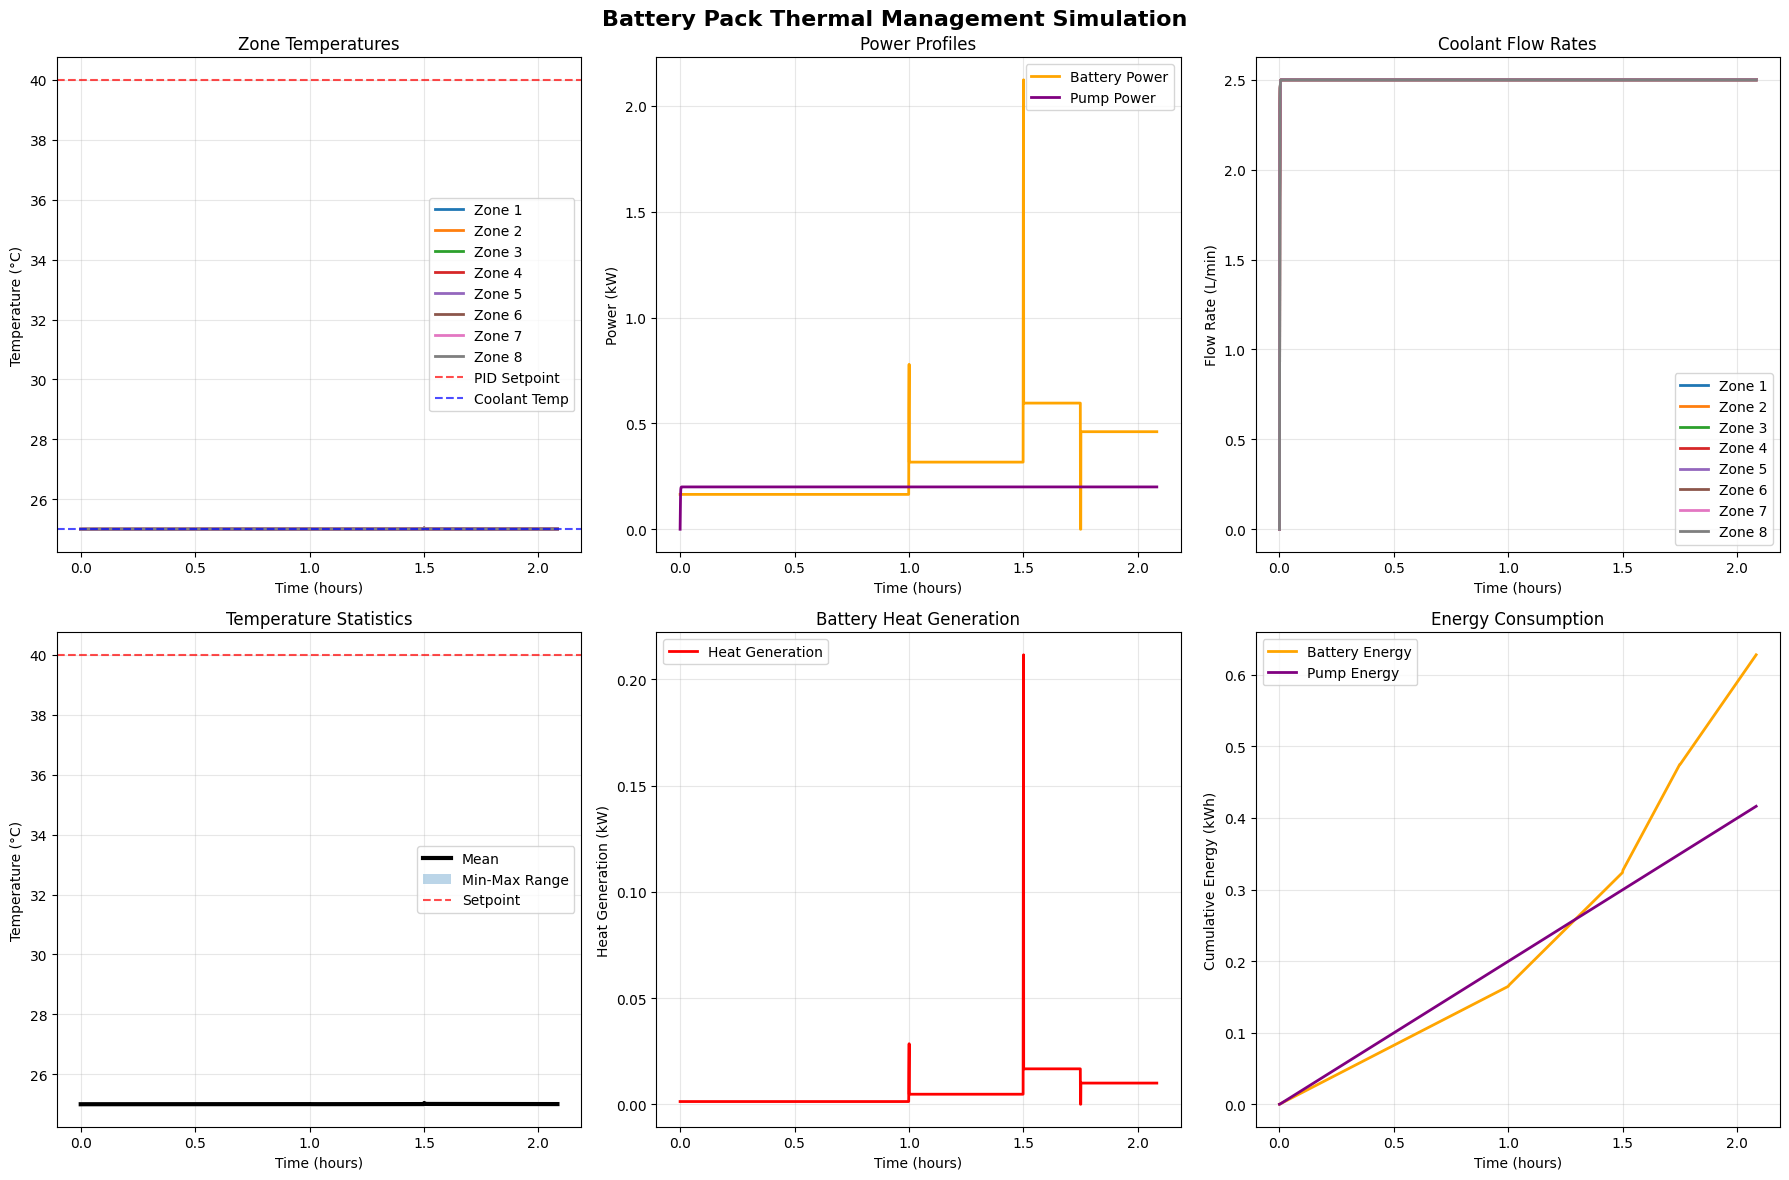

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Battery Pack Thermal Management Simulation', fontsize=16, fontweight='bold')

# Temperature profiles
ax1 = axes[0, 0]
for i in range(NUM_ZONES):
    ax1.plot(time_array/3600, temperatures[:, i], label=f'Zone {i+1}', linewidth=2)
ax1.axhline(y=TEMP_SETPOINT, color='r', linestyle='--', alpha=0.7, label='PID Setpoint')
ax1.axhline(y=COOLANT_TEMP, color='b', linestyle='--', alpha=0.7, label='Coolant Temp')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Zone Temperatures')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Power profiles
ax2 = axes[0, 1]
ax2.plot(time_array/3600, power_profile/1000, color='orange', label='Battery Power', linewidth=2)
if not ADIABATIC_MODE:
    ax2.plot(time_array/3600, pump_power/1000, color='purple', label='Pump Power', linewidth=2)
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Power (kW)')
ax2.set_title('Power Profiles')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Coolant flows
ax3 = axes[0, 2]
if not ADIABATIC_MODE:
    for i in range(NUM_ZONES):
        flow_lpm = coolant_flows[:, i] * MAX_PUMP_FLOW_LPM / NUM_ZONES
        ax3.plot(time_array/3600, flow_lpm, label=f'Zone {i+1}', linewidth=2)
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Flow Rate (L/min)')
    ax3.set_title('Coolant Flow Rates')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'ADIABATIC MODE\n(No Cooling)', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=14)
    ax3.set_title('Coolant Flow (Disabled)')

# Temperature statistics
ax4 = axes[1, 0]
temp_mean = np.mean(temperatures, axis=1)
temp_max = np.max(temperatures, axis=1)
temp_min = np.min(temperatures, axis=1)
ax4.plot(time_array/3600, temp_mean, 'k-', label='Mean', linewidth=3)
ax4.fill_between(time_array/3600, temp_min, temp_max, alpha=0.3, label='Min-Max Range')
ax4.axhline(y=TEMP_SETPOINT, color='r', linestyle='--', alpha=0.7, label='Setpoint')
ax4.set_xlabel('Time (hours)')
ax4.set_ylabel('Temperature (°C)')
ax4.set_title('Temperature Statistics')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Heat generation
ax5 = axes[1, 1]
pack_current = power_profile / PACK_NOMINAL_VOLTAGE
total_heat = np.zeros(len(time_array))
for i in range(NUM_ZONES):
    zone_heat = (pack_current ** 2) * zone_resistance[i]
    total_heat += zone_heat
ax5.plot(time_array/3600, total_heat/1000, color='red', label='Heat Generation', linewidth=2)
ax5.set_xlabel('Time (hours)')
ax5.set_ylabel('Heat Generation (kW)')
ax5.set_title('Battery Heat Generation')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Energy balance
ax6 = axes[1, 2]
cumulative_battery = np.cumsum(power_profile) / 3600 / 1000  # kWh
cumulative_pump = np.cumsum(pump_power) / 3600 / 1000  # kWh
ax6.plot(time_array/3600, cumulative_battery, color='orange', label='Battery Energy', linewidth=2)
if not ADIABATIC_MODE:
    ax6.plot(time_array/3600, cumulative_pump, color='purple', label='Pump Energy', linewidth=2)
ax6.set_xlabel('Time (hours)')
ax6.set_ylabel('Cumulative Energy (kWh)')
ax6.set_title('Energy Consumption')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [12]:
results_df = pd.DataFrame({
    'Time_s': time_array,
    'Time_h': time_array / 3600,
    'Battery_Power_W': power_profile,
    'Pump_Power_W': pump_power,
    'Total_Flow_LPM': total_flow_rate,
    'Pack_Current_A': power_profile / PACK_NOMINAL_VOLTAGE,
})
for i in range(NUM_ZONES):
    results_df[f'Zone_{i+1}_Temp_C'] = temperatures[:, i]
for i in range(NUM_ZONES):
    results_df[f'Zone_{i+1}_Flow_LPM'] = coolant_flows[:, i] * MAX_PUMP_FLOW_LPM / NUM_ZONES
results_df['Mean_Temp_C'] = np.mean(temperatures, axis=1)
results_df['Max_Temp_C'] = np.max(temperatures, axis=1)
results_df['Min_Temp_C'] = np.min(temperatures, axis=1)
results_df['Temp_Spread_K'] = results_df['Max_Temp_C'] - results_df['Min_Temp_C']
results_df.to_csv(OUTPUT_PATH, index=False)
print(f"💾 Results saved to: {OUTPUT_PATH}")

💾 Results saved to: /home/keshav/Documents/reserch_code/simulated_battery_cooling.csv


## Performance Summary

In [13]:
print("\n" + "="*60)
print("🎯 BATTERY PACK THERMAL SIMULATION SUMMARY")
print("="*60)
print(f"📦 PACK CONFIGURATION:")
print(f"   Architecture: {CELLS_IN_SERIES}s{CELLS_IN_PARALLEL}p ({TOTAL_CELLS} cells)")
print(f"   Energy capacity: {PACK_ENERGY:.1f} kWh")
print(f"   Max power: {PACK_MAX_POWER:.0f} kW")
print(f"   Thermal zones: {NUM_ZONES}")
print(f"\n⏱️ SIMULATION:")
print(f"   Duration: {len(time_array)/3600:.1f} hours ({len(time_array)} seconds)")
print(f"   Mode: {'Adiabatic (no cooling)' if ADIABATIC_MODE else 'Active liquid cooling'}")
print(f"\n🌡️ THERMAL PERFORMANCE:")
print(f"   Initial temperature: {temp_stats['initial']:.1f}°C")
print(f"   Final average temperature: {temp_stats['final']:.1f}°C")
print(f"   Maximum temperature: {temp_stats['max']:.1f}°C")
print(f"   Temperature rise: {temp_stats['max'] - temp_stats['initial']:.1f}°C")
print(f"   Final zone spread: {temp_stats['final_spread']:.1f}°C")
print(f"\n⚡ ENERGY ANALYSIS:")
print(f"   Battery energy delivered: {energy_stats['battery_total_kwh']:.2f} kWh")
print(f"   Peak battery power: {energy_stats['battery_peak_kw']:.1f} kW")
print(f"   Battery utilization: {energy_stats['battery_peak_kw']/PACK_MAX_POWER:.1%} of max")
if not ADIABATIC_MODE:
    print(f"   Pump energy consumed: {energy_stats['pump_total_wh']:.1f} Wh")
    print(f"   Peak pump power: {energy_stats['pump_peak_w']:.1f} W")
    print(f"   Cooling overhead: {energy_stats['pump_total_wh']/1000/energy_stats['battery_total_kwh']:.2%}")
    if temp_stats['max'] < 50:
        print(f"   Cooling status: ✅ EFFECTIVE")
    elif temp_stats['max'] < 60:
        print(f"   Cooling status: ⚠️ MARGINAL")
    else:
        print(f"   Cooling status: ❌ INSUFFICIENT")
print("="*60)
print("🎉 Simulation completed successfully!")


🎯 BATTERY PACK THERMAL SIMULATION SUMMARY
📦 PACK CONFIGURATION:
   Architecture: 96s4p (384 cells)
   Energy capacity: 4.3 kWh
   Max power: 13 kW
   Thermal zones: 8

⏱️ SIMULATION:
   Duration: 2.1 hours (7500 seconds)
   Mode: Active liquid cooling

🌡️ THERMAL PERFORMANCE:
   Initial temperature: 25.0°C
   Final average temperature: 25.0°C
   Maximum temperature: 25.0°C
   Temperature rise: 0.0°C
   Final zone spread: 0.0°C

⚡ ENERGY ANALYSIS:
   Battery energy delivered: 0.63 kWh
   Peak battery power: 2.1 kW
   Battery utilization: 16.6% of max
   Pump energy consumed: 416.4 Wh
   Peak pump power: 200.0 W
   Cooling overhead: 66.30%
   Cooling status: ✅ EFFECTIVE
🎉 Simulation completed successfully!
